In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
raw = pd.read_csv('vowel.train')
X = raw.iloc[:, 2:]
y = raw.y
yX = raw.iloc[:, 1:]

In [4]:
raw = pd.read_csv('vowel.test')
tX = raw.iloc[:, 2:]
ty = raw.y
tyX = raw.iloc[:, 1:]

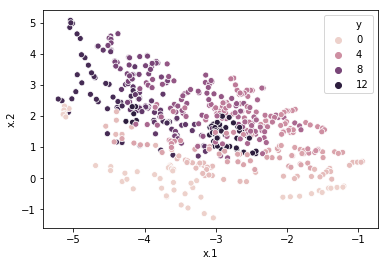

In [5]:
sns.scatterplot(data=yX, x='x.1', y='x.2', hue='y')

In [6]:
beta = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))
y_ = X.dot(beta)

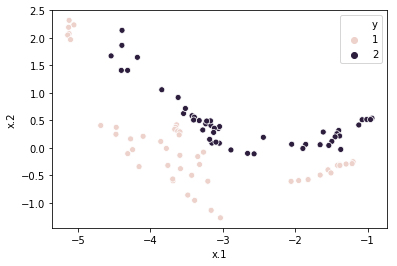

In [7]:
sns.scatterplot(data=yX.loc[yX.y < 3], x='x.1', y='x.2', hue='y', legend='full')

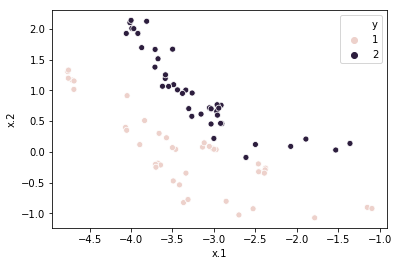

In [8]:
sns.scatterplot(data=tyX.loc[tyX.y < 3], x='x.1', y='x.2', hue='y', legend='full')

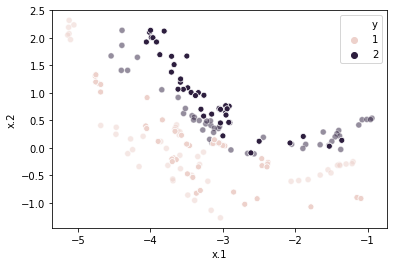

In [9]:
sns.scatterplot(data=yX.loc[yX.y < 3], x='x.1', y='x.2', hue='y', legend=None, alpha=.5)
sns.scatterplot(data=tyX.loc[tyX.y < 3], x='x.1', y='x.2', hue='y', legend='full')

In [10]:
from sklearn import linear_model, neural_network

In [12]:
machine = neural_network.MLPClassifier(hidden_layer_sizes=(4,2),
                                       activation='logistic',
                                       solver='lbfgs',
                                       alpha=0.00,
                                       learning_rate_init=0.01,
                                       learning_rate='constant',
                                       max_iter=200)

machine.fit(X=X.loc[yX.y < 3], y=y.loc[yX.y < 3])
print('score:\n  in-sample: %.3f\n  out-sample: %.3f' 
      % (machine.score(X.loc[yX.y < 3], y.loc[yX.y < 3]), machine.score(tX.loc[tyX.y < 3], ty.loc[tyX.y < 3])))

score:
  in-sample: 0.667
  out-sample: 0.548


## Vanilla Neural Networks

In [13]:
class vnn:
    
    def __init__(self,
#                activation='sigmoid',
               hidden_layer_sizes=(4, 2),
               learning_rate=.01,
               alpha=1e-03,
               epsilon=1e-02,
               max_iter=200):
        
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.alpha = alpha
        self.epsilon = epsilon
        self.max_iter = max_iter
        
        i = hidden_layer_sizes[0]
        self.W = [np.ones((i, 4))]
        self.y = [np.zeros((i,))]
        for j in hidden_layer_sizes[1:]:
            self.W.append(np.ones((j, i+1)))
            self.y.append(np.zeros((j,)))
            i = j
        self.W.append(np.ones((1, j+1)))
        self.y.append(np.zeros(1,))
        
        self.sig = lambda x: 1 / (1 + np.exp(-x))
        self.dsig = lambda sg: sg * (1 - sg)
        
        self.dW = [np.zeros(W.shape) for W in self.W]
        self.dy = [self.dsig(y) for y in self.y]
        
    def _standardize(self, X):
        
        mu = np.tile(X.mean(axis=0), X.shape)
        sig = np.tile(X.std(axix=0), X.shape)
        
        return (X - mu) / sig
        
    def _forward(self, x):
        
        y = x
        for j in range(len(self.W)):
            y = self.sig(self.W[j].dot(np.r_[1, y]))
            self.y[j] = y
            
        return y
        
    def _backprop(self, y, x):
        
        self.dy[-1] = self.dsig(self.y[-1]) * (self.y[-1] - y)
        self.dW[-1] = np.outer(self.dy[-1], np.r_[1, self.y[-2]])
        for j in range(len(self.hidden_layer_sizes) - 1, 0, -1):
            self.dy[j] = self.dsig(self.y[j]) * self.W[j+1][:,1:].T.dot(self.dy[j+1])
            self.dW[j] = np.outer(self.dy[j], np.r_[1, self.y[j-1]])
        self.dy[0] = self.dsig(self.y[0]) * self.W[1][:,1:].T.dot(self.dy[1])
        self.dW[0] = np.outer(self.dy[0], np.r_[1, x])
            
    def _loss(self, y, yhat):
        
        return ((y - yhat) ** 2).mean()
        
    def fit(self, X, y):
        
        self.W[0] = np.ones((self.hidden_layer_sizes[0], X.shape[1] + 1))
        yhat = np.zeros(y.shape)
        self.err = np.ones((self.max_iter,))
        
        for epoch in range(self.max_iter):
            for j in range(X.shape[0]):
                x = X[j]
                yhat[j] = self._forward(x)
                self._backprop(y[j], x)
                
                for i in range(len(self.W)):
                    self.W[i] -= self.learning_rate * self.dW[i]
                    
            self.err[epoch] = self._loss(y, yhat)
#             if self._loss(y, yhat) < self.epsilon:
            if self.err[epoch] < self.epsilon:
                return
    
    def predict(self, X):
        
        y = np.zeros((X.shape[0],))
        for j in range(X.shape[0]):
            y[j] = self._forward(X[j])
            
        return y

In [14]:
o = vnn(hidden_layer_sizes=(4,2), learning_rate=.1, max_iter=300)

In [15]:
o.fit(X=X.loc[yX.y < 3].values, y=y.loc[yX.y < 3].values - 1)

In [16]:
o._loss(y=y.loc[yX.y < 3].values - 1, yhat=o.predict(X.loc[yX.y < 3].values))

0.06760700555059013

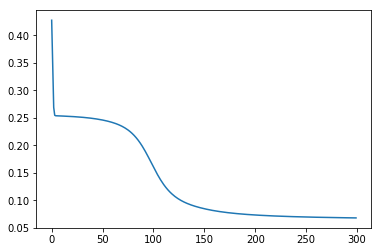

In [17]:
plt.plot(o.err)

In [18]:
o._loss(y=y.loc[yX.y < 3].values - 1, yhat=o.predict(X.loc[yX.y < 3].values))

0.06760700555059013

In [19]:
tmp = o.predict(X.loc[yX.y < 3].values)
yhat = np.zeros(tmp.shape)
yhat[tmp > .5] = 1
yhat[tmp <= .5] = 0

In [20]:
1 - np.abs(yhat - (y.loc[yX.y < 3].values - 1)).sum() / yhat.size

0.9270833333333334

In [21]:
cmap = plt.get_cmap('tab10').colors

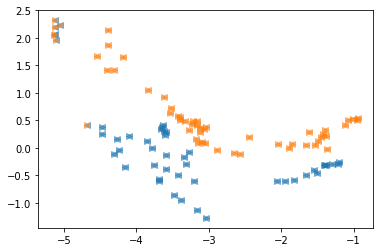

In [23]:
plt.plot(yX.loc[yX.y == 1]['x.1'], yX.loc[yX.y == 1]['x.2'], '<', color=cmap[0], alpha=.5)
plt.plot(yX.loc[yX.y == 2]['x.1'], yX.loc[yX.y == 2]['x.2'], '<', color=cmap[1], alpha=.5)
plt.plot(yX.loc[yX.y < 3].loc[yhat == 0]['x.1'], yX.loc[yX.y < 3].loc[yhat == 0]['x.2'], '>', color=cmap[0], alpha=.5)
plt.plot(yX.loc[yX.y < 3].loc[yhat == 1]['x.1'], yX.loc[yX.y < 3].loc[yhat == 1]['x.2'], '>', color=cmap[1], alpha=.5)

In [24]:
o._loss(y=ty.loc[tyX.y < 3].values - 1, yhat=o.predict(tX.loc[tyX.y < 3].values))

0.15688474083266696

In [25]:
tmp = o.predict(tX.loc[tyX.y < 3].values)
yhat = np.zeros(tmp.shape)
yhat[tmp > .5] = 1
yhat[tmp <= .5] = 0

In [26]:
1 - np.abs(yhat - (ty.loc[tyX.y < 3].values - 1)).sum() / yhat.size

0.8095238095238095

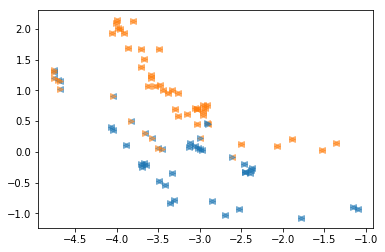

In [27]:
plt.plot(tyX.loc[tyX.y == 1]['x.1'], tyX.loc[tyX.y == 1]['x.2'], '<', color=cmap[0], alpha=.5)
plt.plot(tyX.loc[tyX.y == 2]['x.1'], tyX.loc[tyX.y == 2]['x.2'], '<', color=cmap[1], alpha=.5)
plt.plot(tyX.loc[tyX.y < 3].loc[yhat == 0]['x.1'], tyX.loc[tyX.y < 3].loc[yhat == 0]['x.2'], '>', color=cmap[0], alpha=.5)
plt.plot(tyX.loc[tyX.y < 3].loc[yhat == 1]['x.1'], tyX.loc[tyX.y < 3].loc[yhat == 1]['x.2'], '>', color=cmap[1], alpha=.5)